In [2]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import eig, norm, det
from scipy.linalg import inv
from scipy.stats import multivariate_normal

%matplotlib notebook

In [3]:
def ellipse(sigma, mean, scale=1):
    
    d, v = eig(inv(sigma))
    mat = v @ inv(np.sqrt(np.diag(d)))

    N = 200
    t = np.arange(0, N) * (2*np.pi) / N

    Y1 = scale * np.cos(t)
    Y2 = scale * np.sin(t)
   
    Y = np.array([Y1, Y2])

    X = mat.dot(Y)

    X1 = X[0]
    X2 = X[1]

    # move ellipse to mean_k
    X1 = X1 + mean[0]
    X2 = X2 + mean[1]
    
    return X1, X2

In [4]:
def plot(samples, parameters):

    data = samples.T
    gammas = parameters["gammas"]
    
    x = data[0]
    y = data[1]
    
    colors = [tuple(gammas[n]) for n in range(len(gammas))]
    scales = [2, 2, 2]
    
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    ax.scatter(x, y, alpha=0.8, c=colors, edgecolors='none', s=30)
    
    for k in range(3):
        X1, X2 = ellipse(parameters["sigmas"][k], parameters["means"][k], scale=scales[k])
        ax.plot(X1, X2, c="black")
    
    plt.title('EM - 1,2,3')
    plt.show()

In [5]:
def get_random_means(train):

    train_a = train["1"]
    train_o = train["2"]
    train_u = train["3"]
    
    points_a = [train_a[random.randrange(0, len(train_a))] for i in range(5)]
    points_o = [train_o[random.randrange(0, len(train_o))] for i in range(5)]
    points_u = [train_u[random.randrange(0, len(train_u))] for i in range(5)]

    data = {
        "1": points_a,
        "2": points_o,
        "3": points_u
    }
    
    means = [
        np.mean(points_a, axis=0),
        np.mean(points_o, axis=0),
        np.mean(points_u, axis=0)
    ]
    
    return means, data

In [33]:
def get_zone_division_means(train):
    
    train_a = train["1"]
    train_o = train["2"]
    train_u = train["3"]
    
    samples = np.array(list(train_a) + list(train_o) + list(train_u))
    
    mean = np.mean(samples, axis=0)
    
    samples_moved = np.array(list(map(lambda x: x - mean, samples)))
    phases = np.array(list(map(lambda x: np.mod(np.arctan2(x[1], x[0]), 2*np.pi), samples_moved)))
    
    samples_phases = list(zip(samples, phases))
    
    sample_phase_1 = list(filter(lambda x: x[1] > 0.0 and x[1] <= (2/3)*np.pi, samples_phases))
    sample_phase_2 = list(filter(lambda x: x[1] > (2/3)*np.pi and x[1] <= (4/3)*np.pi, samples_phases))
    sample_phase_3 = list(filter(lambda x: x[1] > (4/3)*np.pi and x[1] < 2*np.pi, samples_phases))
        
    sample_1 = list(map(lambda x: x[0], sample_phase_1))
    sample_2 = list(map(lambda x: x[0], sample_phase_2))
    sample_3 = list(map(lambda x: x[0], sample_phase_3))

    means = [np.mean(sample_1, axis=0), np.mean(sample_2, axis=0), np.mean(sample_3, axis=0)]

    data = {
        "1": sample_1,
        "2": sample_2,
        "3": sample_3
    }
    
    return means, data

In [6]:
def get_sigma(data):

    d1 = data["1"]
    d2 = data["2"]
    d3 = data["3"]
    
    return (1/3) * (np.cov(d1, rowvar=False) + np.cov(d2, rowvar=False) + np.cov(d2, rowvar=False))

In [46]:
def parse():

    # parse data
    with open('a.txt') as f:
        lines_a = list(csv.reader(f, delimiter='\t'))

    with open('o.txt') as f:
        lines_o = list(csv.reader(f, delimiter='\t'))

    with open('u.txt') as f:
        lines_u = list(csv.reader(f, delimiter='\t'))

    lines_a = list(map(lambda x: [int(x[0]), int(x[1])],lines_a))
    lines_o = list(map(lambda x: [int(x[0]), int(x[1])],lines_o))
    lines_u = list(map(lambda x: [int(x[0]), int(x[1])],lines_u))

    np.random.shuffle(lines_a)
    np.random.shuffle(lines_o)
    np.random.shuffle(lines_u)
    
    # separate 'train' and 'test' datasets
    train_a = np.array(lines_a[:35])
    test_a = np.array(lines_a[35:])
    
    train_o = np.array(lines_o[:35])
    test_o = np.array(lines_o[35:])
    
    train_u = np.array(lines_u[:35])
    test_u = np.array(lines_u[35:])
    
    samples = np.array(list(train_a) + list(train_o) + list(train_u))
    
    data = {
        "train": {
            "1": train_a,
            "2": train_o,
            "3": train_u
        },
        "test": {
            "1": test_a,
            "2": test_o,
            "3": test_u
        }
    }
    
    return samples, data

In [47]:
samples, datasets = parse()

## EM

In [9]:
def calc_L(samples, means, sigmas, pi):
    
    x = samples
    
    return sum([np.log(sum([multivariate_normal.pdf(x[n], mean=means[k], cov=sigmas[k])*pi[k] for k in range(3)])) for n in range(len(samples))])

In [10]:
def calc_means(samples, gammas):

    # calc denominator
    den = calc_denom(gammas)
    
    m = np.array([sum([samples[n]*gammas[n][k] for n in range(len(samples))]) for k in range(3)])
    
    return np.array([m[i]/den[i] for i in range(len(m))])

In [11]:
def calc_sigmas(samples, means, gammas):

    # calc denominator
    den = calc_denom(gammas)
    
    sigmas = []
    sigmas_k = []
    
    for k in range(3):
        for n in range(len(samples)):
            res = np.array(list(map(lambda y: [y], samples[n]-means[k])))
            s = gammas[n][k] * res @ res.T
            sigmas_k.append(s)
        sigmas.append(sum(sigmas_k) / den[k])
        sigmas_k.clear()
    
    return sigmas

In [12]:
def calc_pi(gammas, N):

    num = calc_denom(gammas)
    
    return num / N

In [13]:
# calculates the sum of gammas
# for all the classses
# returns:
#   [sum(gammas[0]), sum(gammas[1]), sum(gammas[2])]
def calc_denom(gammas):

    N = len(gammas)
    
    d = np.array([sum([gammas[n][k] for n in range(N)]) for k in range(3)])
    
    return d

In [14]:
def gamma(sample, means, sigmas, pi):
    
    nums = np.array([multivariate_normal.pdf(sample, mean=means[k], cov=sigmas[k])*pi[k] for k in range(3)])

    den = nums.sum()
    
    return nums / den

In [43]:
def em(samples, means, sigmas, pi):

    it = 0
    L = np.zeros(2)
    L[0] = 0.0
    L[1] = calc_L(samples, means, sigmas, pi)
    deltaL = L[1] - L[0]
    
    while abs(deltaL) > 0.01:

        ############
        # 'E' step #
        ############
        gammas = np.array([gamma(samples[i], means, sigmas, pi) for i in range(len(samples))])

        ############
        # 'M' step #
        ############
        
        # calc new means
        means = calc_means(samples, gammas)

        # calc new sigmas
        sigmas = calc_sigmas(samples, means, gammas)

        # calc new pi
        pi = calc_pi(gammas, len(samples))

        L[0] = L[1]
        L[1] = calc_L(samples, means, sigmas, pi)
        deltaL = L[1] - L[0]
        it += 1

    return means, sigmas, gammas, pi, it

## EM classification

In [18]:
def clasify(test, g1, g2, g3, which):

    positive = 0

    for sample in test:
        
        predictions = [(g1(sample), "1"), (g2(sample), "2"), (g3(sample), "3")]
        prob, k = max(predictions, key=lambda x: x[0])
        
        if k == which:
            positive += 1

    return positive

In [19]:
def g(x, mean, sigma, w):

    y = x - mean
    
    return np.log(w) - 0.5 * (np.log(det(sigma)) + y.T @ inv(sigma) @ y)

#### With means generated with five random points

In [48]:
# obtain first means
# by calc the mean of 5 random
# points in samples
means, data = get_random_means(datasets["train"])

# obtain first sigmas
# by calc the average of the sigma
# of each class
sigma = get_sigma(data)

sigmas = np.array([sigma, sigma, sigma])
pi = np.array([(1/3) for i in range(3)])

means, sigmas, gammas, pi, it = em(samples, means, sigmas, pi)

parameters_five_points = {
    "means": means,
    "sigmas": sigmas,
    "gammas": gammas
}

print("Iter: {}".format(it))

Iter: 15


In [49]:
test = datasets["test"]

mean_1 = np.mean(test["1"], axis=0)
mean_2 = np.mean(test["2"], axis=0)
mean_3 = np.mean(test["3"], axis=0)

class_1 = np.argmin([norm(mean_1 - means[k]) for k in range(3)])
class_2 = np.argmin([norm(mean_2 - means[k]) for k in range(3)])
class_3 = np.argmin([norm(mean_3 - means[k]) for k in range(3)])

# create the mapping
mapping = {
    "1": class_1,
    "2": class_2,
    "3": class_3
}

# calculate g functions
g1 = lambda x: g(x, means[mapping["1"]], sigmas[mapping["1"]], pi[mapping["1"]])
g2 = lambda x: g(x, means[mapping["2"]], sigmas[mapping["2"]], pi[mapping["2"]])
g3 = lambda x: g(x, means[mapping["3"]], sigmas[mapping["3"]], pi[mapping["3"]])

positive_1 = clasify(datasets["test"]["1"], g1, g2, g3, "1")
positive_2 = clasify(datasets["test"]["2"], g1, g2, g3, "2")
positive_3 = clasify(datasets["test"]["3"], g1, g2, g3, "3")

print("Test for class 1 - accuracy: {}".format(positive_1/len(datasets["test"]["1"])))
print("Test for class 2 - accuracy: {}".format(positive_2/len(datasets["test"]["2"])))
print("Test for class 3 - accuracy: {}".format(positive_3/len(datasets["test"]["3"])))

Test for class 1 - accuracy: 1.0
Test for class 2 - accuracy: 1.0
Test for class 3 - accuracy: 0.8666666666666667


#### With means generated with XY-plane division in 3 zones

In [50]:
# obtain first means
# by calc the mean of
# points in the samples' zones 
means, data = get_zone_division_means(datasets["train"])

# obtain first sigmas
# by calc the average of the sigma
# of each class
sigma = get_sigma(data)

sigmas = np.array([sigma, sigma, sigma])
pi = np.array([(1/3) for i in range(3)])

means, sigmas, gammas, pi, it = em(samples, means, sigmas, pi)

parameters_zones = {
    "means": means,
    "sigmas": sigmas,
    "gammas": gammas
}

print("Iter: {}".format(it))

Iter: 17


In [51]:
test = datasets["test"]

mean_1 = np.mean(test["1"], axis=0)
mean_2 = np.mean(test["2"], axis=0)
mean_3 = np.mean(test["3"], axis=0)

class_1 = np.argmin([norm(mean_1 - means[k]) for k in range(3)])
class_2 = np.argmin([norm(mean_2 - means[k]) for k in range(3)])
class_3 = np.argmin([norm(mean_3 - means[k]) for k in range(3)])

# create the mapping
mapping = {
    "1": class_1,
    "2": class_2,
    "3": class_3
}

# calculate g functions
g1 = lambda x: g(x, means[mapping["1"]], sigmas[mapping["1"]], pi[mapping["1"]])
g2 = lambda x: g(x, means[mapping["2"]], sigmas[mapping["2"]], pi[mapping["2"]])
g3 = lambda x: g(x, means[mapping["3"]], sigmas[mapping["3"]], pi[mapping["3"]])

positive_1 = clasify(datasets["test"]["1"], g1, g2, g3, "1")
positive_2 = clasify(datasets["test"]["2"], g1, g2, g3, "2")
positive_3 = clasify(datasets["test"]["3"], g1, g2, g3, "3")

print("Test for class 1 - accuracy: {}".format(positive_1/len(datasets["test"]["1"])))
print("Test for class 2 - accuracy: {}".format(positive_2/len(datasets["test"]["2"])))
print("Test for class 3 - accuracy: {}".format(positive_3/len(datasets["test"]["3"])))

Test for class 1 - accuracy: 1.0
Test for class 2 - accuracy: 0.5333333333333333
Test for class 3 - accuracy: 1.0


## Plotting

<IPython.core.display.Javascript object>


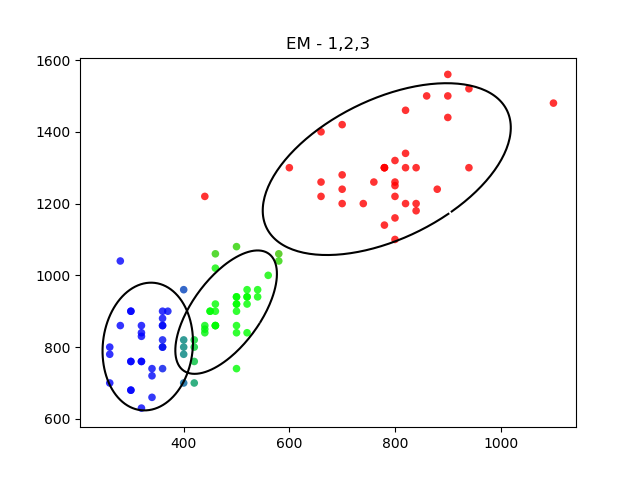

In [52]:
plot(samples, parameters_five_points)

<IPython.core.display.Javascript object>


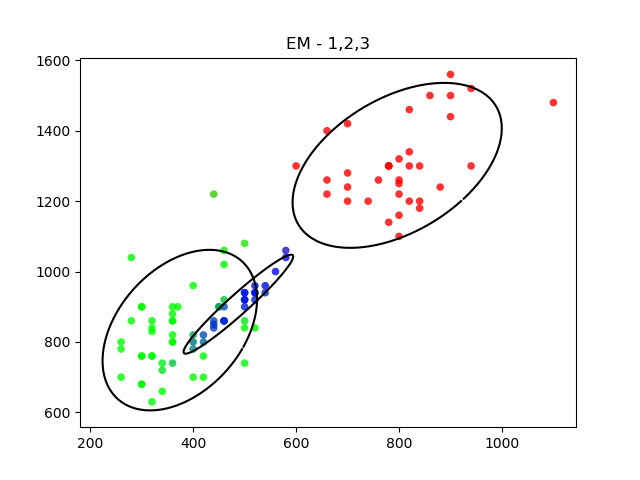

In [53]:
plot(samples, parameters_zones)